In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import json
from pathlib import Path

# --------------------------------------------------------------------
# 1. Setup and Data Load
# --------------------------------------------------------------------
data_dir = Path("/home/beatriz/Documents/2. Documents/2. USP/4. TCC/literary-knowledge-network/data")
out_dir = data_dir / "output/figures"
out_dir.mkdir(parents=True, exist_ok=True)

work_path = data_dir / "processed/enriched/work_final.csv"
comm_path = data_dir / "output/communities/work_communities.csv"
results_metrics_candidates = [
    data_dir / "output/results_metrics.json",
    data_dir / "output/analysis/results_metrics.json",
]

results_metrics_path = None
for candidate in results_metrics_candidates:
    if candidate.exists():
        results_metrics_path = candidate
        break
if results_metrics_path is None:
    results_metrics_path = results_metrics_candidates[0]

works = pd.read_csv(work_path)
communities = pd.read_csv(comm_path)
df = communities.merge(works, on="work_id", how="left")

print(f"✅ Loaded {len(df)} works and {df['cluster_id'].nunique()} communities.")


✅ Loaded 2470 works and 86 communities.


Edge overlap summary: {'Only SBERT': 20118, 'Only TF–IDF': 203, 'Intersection': 128, 'Hybrid (final)': 4818}


/tmp/ipykernel_103903/634489821.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="plasma")


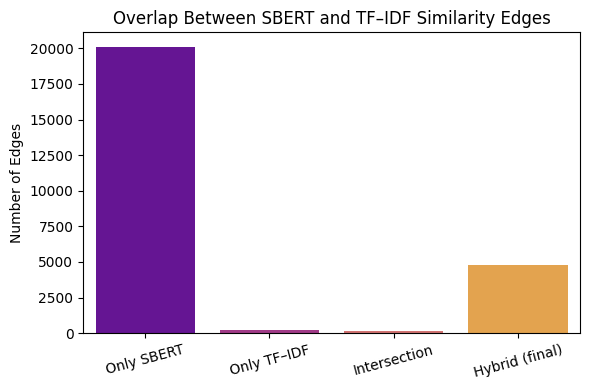

In [9]:
# --------------------------------------------------------------------
# 2. SBERT vs TF–IDF Edge Overlap Analysis
# --------------------------------------------------------------------
edges_dir = data_dir / "output/edges"

try:
    edges_sbert = pd.read_csv(edges_dir / "sbert_edges.csv")
    edges_tfidf = pd.read_csv(edges_dir / "tfidf_edges.csv")
    edges_hybrid = pd.read_csv(edges_dir / "hybrid_edges.csv")
except FileNotFoundError:
    print("⚠️ Edge files not found — skipping SBERT/TF–IDF comparison section.")
    edges_sbert = edges_tfidf = edges_hybrid = None

def normalize_edges(df):
    """Normalize edges so direction doesn’t matter."""
    if "weight" not in df.columns:
        df["weight"] = 1.0
    df["pair"] = df.apply(lambda r: tuple(sorted((r["source"], r["target"]))), axis=1)
    return df

if edges_sbert is not None:
    edges_sbert = normalize_edges(edges_sbert)
    edges_tfidf = normalize_edges(edges_tfidf)
    edges_hybrid = normalize_edges(edges_hybrid)

    sbert_set = set(edges_sbert["pair"])
    tfidf_set = set(edges_tfidf["pair"])
    hybrid_set = set(edges_hybrid["pair"])

    only_sbert = sbert_set - tfidf_set
    only_tfidf = tfidf_set - sbert_set
    intersection = sbert_set & tfidf_set

    counts = {
        "Only SBERT": len(only_sbert),
        "Only TF–IDF": len(only_tfidf),
        "Intersection": len(intersection),
        "Hybrid (final)": len(hybrid_set)
    }
    print("Edge overlap summary:", counts)

    plt.figure(figsize=(6,4))
    sns.barplot(x=list(counts.keys()), y=list(counts.values()), palette="plasma")
    plt.ylabel("Number of Edges")
    plt.xticks(rotation=15)
    plt.title("Overlap Between SBERT and TF–IDF Similarity Edges")
    plt.tight_layout()
    plt.savefig(out_dir / "sbert_tfidf_overlap.png", dpi=300)
    plt.show()


Top 10 hubs by degree:
                             original_title  degree  weighted_degree  \
423                        By Blood We Live      29             29.0   
691                       Wolf on a mission      28             28.0   
536                      Taming the Vampire      24             24.0   
333                     Things in the Night      19             19.0   
8                              Significance      19             19.0   
690                                Cry Wolf      18             18.0   
19           The Joker: Death of the Family      17             17.0   
354                          The Highlander      17             17.0   
26           Batman, Volume 2: I Am Suicide      17             17.0   
176  Witch Hunt (Black Sorcery Trilogy, #1)      16             16.0   

     cluster_id  
423           0  
691           5  
536           0  
333           5  
8             1  
690           5  
19           22  
354          13  
26           22  
176

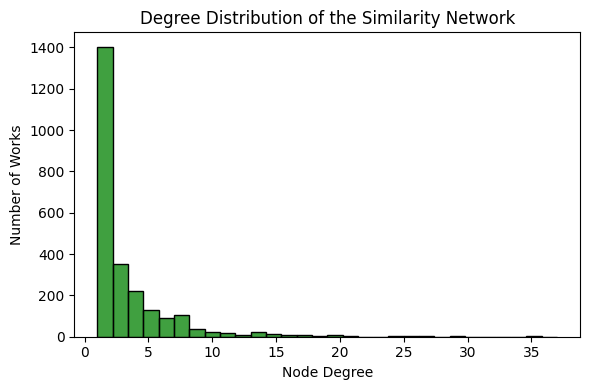

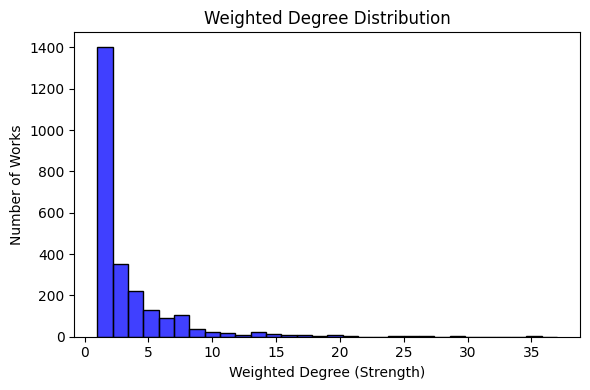

In [10]:
# --------------------------------------------------------------------
# 3. Centrality of Hubs (Degree, Weighted Degree, Betweenness)
# --------------------------------------------------------------------
if edges_hybrid is not None:
    # Build weighted graph
    G = nx.from_pandas_edgelist(edges_hybrid, "source", "target", edge_attr="weight")

    # Compute centralities
    degree = dict(G.degree())
    weighted_degree = dict(G.degree(weight="weight"))
    betweenness = nx.betweenness_centrality(G, k=min(500, len(G)), weight="weight", normalized=True, seed=42)

    df["degree"] = df["work_id"].map(degree)
    df["weighted_degree"] = df["work_id"].map(weighted_degree)
    df["betweenness"] = df["work_id"].map(betweenness)

    hubs = (
        df[["original_title","degree","weighted_degree","betweenness","cluster_id","best_book_description"]]
        .dropna()
        .sort_values("degree", ascending=False)
        .head(10)
    )

    print("\nTop 10 hubs by degree:")
    print(hubs[["original_title","degree","weighted_degree","cluster_id"]])

    hubs.to_csv(out_dir / "top10_hubs_centrality.csv", index=False)

    # Plot degree distributions
    plt.figure(figsize=(6,4))
    sns.histplot(df["degree"].dropna(), bins=30, color="green", edgecolor="black")
    plt.xlabel("Node Degree")
    plt.ylabel("Number of Works")
    plt.title("Degree Distribution of the Similarity Network")
    plt.tight_layout()
    plt.savefig(out_dir / "degree_distribution.png", dpi=300)
    plt.show()

    plt.figure(figsize=(6,4))
    sns.histplot(df["weighted_degree"].dropna(), bins=30, color="blue", edgecolor="black")
    plt.xlabel("Weighted Degree (Strength)")
    plt.ylabel("Number of Works")
    plt.title("Weighted Degree Distribution")
    plt.tight_layout()
    plt.savefig(out_dir / "weighted_degree_distribution.png", dpi=300)
    plt.show()

In [11]:
# --------------------------------------------------------------------
# 4. Assortativity by Publication Year
# --------------------------------------------------------------------
if edges_hybrid is not None:
    df["original_publication_year"] = pd.to_numeric(df["original_publication_year"], errors="coerce")
    year_map = df.set_index("work_id")["original_publication_year"].to_dict()
    nx.set_node_attributes(G, year_map, "year")

    # Filter valid year nodes
    valid_nodes = [n for n, d in G.nodes(data=True) if not np.isnan(d.get("year", np.nan))]
    G_sub = G.subgraph(valid_nodes)

    if G_sub.number_of_nodes() > 1:
        r_year = nx.numeric_assortativity_coefficient(G_sub, "year")
    else:
        r_year = np.nan

    print(f"\nAssortativity by publication year: {r_year:.3f}")


Assortativity by publication year: 0.298


In [12]:
# --------------------------------------------------------------------
# 5. Parameter Grid Summary (Threshold × Top-K)
# --------------------------------------------------------------------
metrics = None
if results_metrics_path and results_metrics_path.exists():
    with open(results_metrics_path, "r", encoding="utf-8") as f:
        metrics = json.load(f)
else:
    print("⚠️ results_metrics.json not found.")

if metrics:
    entries = metrics.get("results") or metrics.get("grid_results") or []
    flat = []
    for entry in entries:
        flat.append({
            "threshold": entry.get("threshold"),
            "top_k": entry.get("top_k"),
            "graph_coverage": entry.get("graph_coverage"),
            "modularity": entry.get("modularity"),
            "median_keyword_purity": entry.get("median_keyword_purity"),
        })
    if flat:
        grid_df = pd.DataFrame(flat)
        if grid_df['median_keyword_purity'].notna().any():
            grid_df = grid_df.dropna(subset=['median_keyword_purity'])
            pivot = grid_df.pivot_table(index="threshold", columns="top_k", values="median_keyword_purity")
            if not pivot.empty:
                plt.figure(figsize=(6,4.5))
                sns.heatmap(pivot, cmap="Greys", annot=True, fmt=".2f")
                plt.xlabel("Top-K")
                plt.ylabel("Threshold")
                plt.title("Median Keyword Purity Across Threshold–Top-K Grid")
                plt.tight_layout()
                plt.savefig(out_dir / "threshold_topk_heatmap.png", dpi=300)
                plt.show()
            else:
                print("⚠️ Parameter grid heatmap skipped (pivot empty).")
            grid_df.to_csv(out_dir / "parameter_grid_summary.csv", index=False)
        else:
            print("⚠️ Median keyword purity values missing; skipping heatmap.")
            pd.DataFrame(flat).to_csv(out_dir / "parameter_grid_summary.csv", index=False)
    else:
        print("⚠️ Parameter grid metrics unavailable in results_metrics.json.")


⚠️ Median keyword purity values missing; skipping heatmap.


In [13]:
# --------------------------------------------------------------------
# 6. Network Summary Metrics
# --------------------------------------------------------------------
if edges_hybrid is not None:
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()
    density = nx.density(G)
    avg_degree = np.mean([d for _, d in G.degree()])
    cc = nx.average_clustering(G)

    summary_metrics = {
        "nodes": num_nodes,
        "edges": num_edges,
        "density": density,
        "average_degree": avg_degree,
        "average_clustering": cc,
        "assortativity_year": r_year,
    }

    print("\nNetwork summary:")
    for k, v in summary_metrics.items():
        print(f"{k}: {v:.4f}" if isinstance(v, (float, int)) else f"{k}: {v}")

    with open(out_dir / "network_summary_metrics.json", "w") as f:
        json.dump(summary_metrics, f, indent=2)

print(f"\n✅ Outputs saved to {out_dir}")


Network summary:
nodes: 3604.0000
edges: 4818.0000
density: 0.0007
average_degree: 2.6737
average_clustering: 0.1509
assortativity_year: 0.2982

✅ Outputs saved to /home/beatriz/Documents/2. Documents/2. USP/4. TCC/literary-knowledge-network/data/output/figures
